In [1]:
%matplotlib inline
from __future__ import division
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

from vis_common import load_store, load_games

FS = (10, 6) # Reasonable default figsize
DECILES = list(np.arange(0.1, 1.0, 0.1))
QUANTILES = [0, .25, .5, .75, .9, .95, 1.]
QUANTILE_LABELS = ['0-25%', '25-50%', '50-75%', '75-90%', '90-95%', '95-100%']

store = load_store()
g = games = load_games()

import winrate
g['wr'] = winrate.smoothed_winrate(g)
g['quantile'] = pd.qcut(g['wr'], q=QUANTILES, labels=QUANTILE_LABELS)

In [2]:
sk = store['skill_progression']

In [3]:
sk.head(10)

,gid,lvl,skill,xl
0,0,3,maces & flails,2
1,15,3,axes,2
2,15,4,axes,4
3,15,5,axes,5
4,15,6,axes,6
5,15,7,axes,7
6,15,9,axes,8
7,15,11,axes,10
8,15,1,invocations,5
9,15,2,invocations,6


In [78]:
def spellcasting_progression(group):
    return sk[(sk['skill']=='spellcasting') & sk['gid'].isin(group.index)]\
        .groupby('lvl')['xl'].mean()
    
quant_groups = [['0-25%', '25-50%'], ['90-95%', '95-100%']]
quant_labels = ['bottom 50%', 'top 10%']
def quant_group(label):
    q = g.loc[label, 'quantile']
    if q in quant_groups[0]:
        return 0
    elif q in quant_groups[1]:
        return 1

In [47]:
def plot_progress(sps, bgs, nlvls=8):
    ppq = progression_per_quantile = g[ (g['species'].isin(sps)) & (g['bg'].isin(bgs)) ]\
        .groupby(quant_group)\
        .apply(spellcasting_progression)

    fig, ax = plt.subplots(figsize=FS)
    transpose = 0
    for quant, label in zip(ppq.index, quant_labels):
        prog = ppq.loc[quant][:nlvls]
        # skill level, XL (the natural ordering)
        x, y = prog.index[:nlvls], prog.values[:nlvls]
        if transpose:
            x, y = y, x
        ax.plot(x, y,
            marker='.',
            linestyle='-', label=label)

    ax.set_ylabel('skill level' if transpose else 'avg. XL')
    ax.set_xlabel('avg. XL' if transpose else 'skill level')
    if transpose:
        ax.set_yticks(ppq.loc[0].index[:nlvls])
    else:
        ax.set_xticks(ppq.loc[0].index[:nlvls])
        y0, y1 = ax.get_ylim()
        ax.set_yticks(np.arange(int(y0), int(y1)+1, 1))
    ax.grid(axis='both')
    ax.legend();
    return ax

In [109]:
import functools
sk = store['skill_progression']

def skill_progression(group, skill='spellcasting', max_level=28):
    return sk[(sk['skill']==skill) & sk['gid'].isin(group.index)]\
        .groupby('lvl')['xl']\
        .mean().reindex(pd.Index(range(max_level)))
    
quant_groups = [['0-25%', '25-50%'], ['90-95%', '95-100%']]
quant_labels = ['bottom 50%', 'top 10%']
def quant_group(label):
    q = g.loc[label, 'quantile']
    if q in quant_groups[0]:
        return 0
    elif q in quant_groups[1]:
        return 1
    
def plot_progress(sps, bgs, skill='spellcasting', max_skill=28, transpose=False):
    min_games = 5
    for qg in quant_groups:
        relevant_games = g[(g['species'].isin(sps)) & (g['bg'].isin(bgs)) 
                           & g['quantile'].isin(qg)]
        games_per_lvl = sk[(sk['skill']==skill) & sk['gid'].isin(relevant_games.index)]\
            .groupby('lvl').size()
        toosmall = (games_per_lvl < min_games)
        if toosmall.any():
            max_skill = min(max_skill, toosmall.argmax())
    
    max_skill = 10
    relevant_games = g[(g['species'].isin(sps)) & (g['bg'].isin(bgs)) ]
    ppq = progression_per_quantile = relevant_games\
        .groupby(quant_group)\
        .apply(skill_progression, skill=skill, max_level=max_skill)\
        .dropna(axis=1) # Drop null columns (= skill levels for which we have no data)

    fig, ax = plt.subplots(figsize=FS)
    for quant, label in zip(ppq.index, quant_labels):
        prog = ppq.loc[quant]
        # skill level, XL (the natural ordering)
        x, y = prog.index, prog.values
        if transpose:
            x, y = y, x
        ax.plot(x, y,
            marker='.',
            linestyle='-', label=label)

    skill_label = '{} level'.format(skill)
    ax.set_ylabel(skill_label if transpose else 'avg. XL')
    ax.set_xlabel('avg. XL' if transpose else skill_label)
    if transpose:
        ax.set_yticks(ppq.loc[0].index)
    else:
        ax.set_xticks(ppq.loc[0].index)
        y0, y1 = ax.get_ylim()
        ax.set_yticks(np.arange(int(y0), int(y1)+1, 1))
    ax.grid(axis='both')
    ax.legend();
    return ax

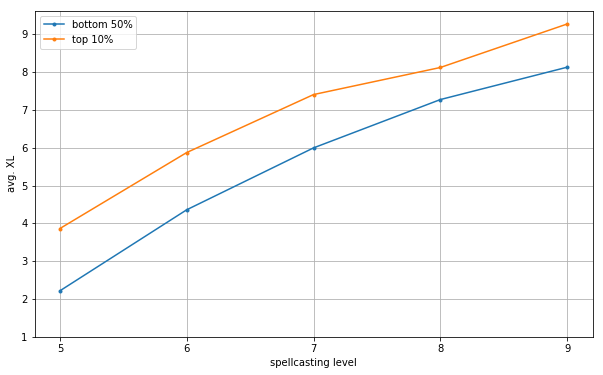

In [110]:
sps = ['deep elf']
bgs = ['wizard']
plot_progress(sps, bgs, max_skill=15);

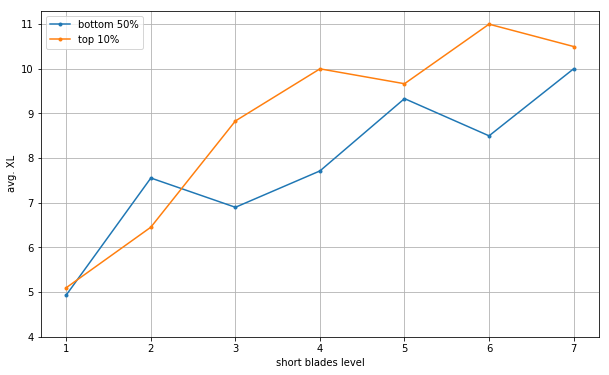

In [111]:
sps = ['deep elf']
bgs = ['wizard']
skill = 'short blades'
plot_progress(sps, bgs, skill=skill, max_skill=10);

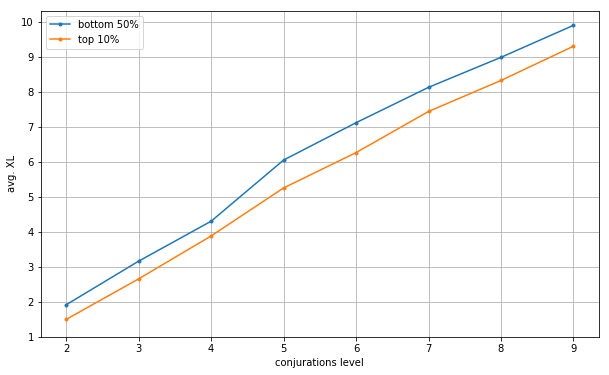

In [116]:
sps = ['deep elf']
bgs = ['wizard']
skill = 'conjurations'
plot_progress(sps, bgs, skill=skill);

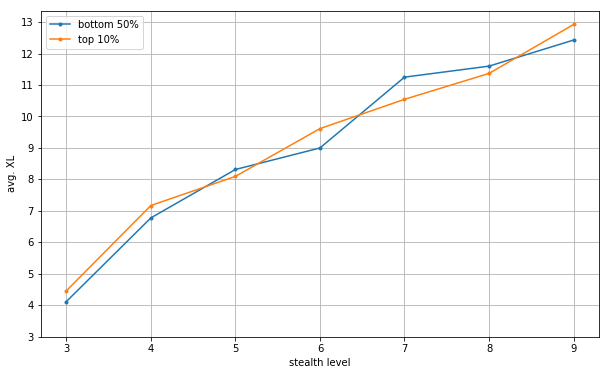

In [117]:
sps = ['deep elf']
bgs = ['wizard']
skill = 'conjurations'
plot_progress(sps, bgs, skill='stealth');

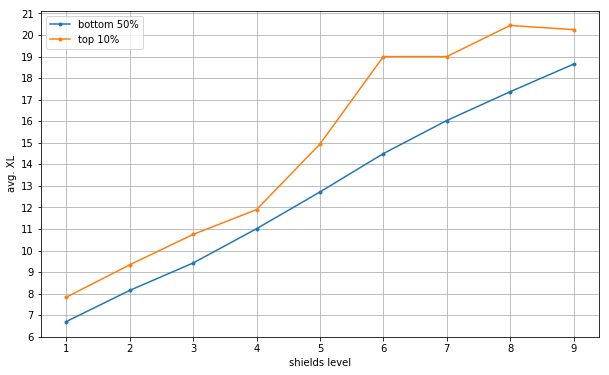

In [118]:
sps = ['deep elf']
bgs = ['wizard', 'conjurer', 'fire elementalist', 'air elementalist', 
      'earth elementalist', 'ice elementalist', 'summoner']
skill = 'shields'
plot_progress(sps, bgs, skill=skill);

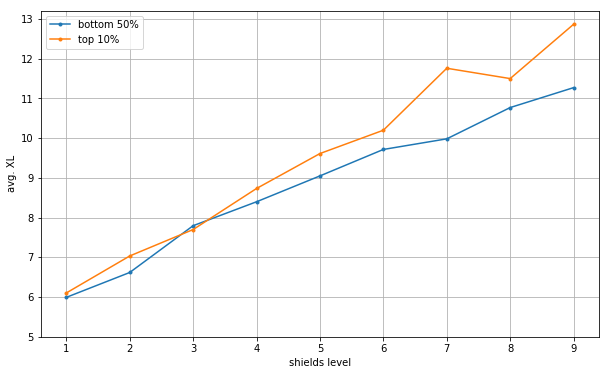

In [153]:
sps = ['minotaur']
bgs = ['berserker']
skill = 'shields'
plot_progress(sps, bgs, skill=skill);

In [135]:
def _get_skill(grp, skill, xl, default):
    rows = grp[(grp['skill']==skill) & (grp['xl'] <= xl)]
    if len(rows) == 0:
        return default
    i = rows['xl'].argmax()
    return rows.loc[i, 'lvl']

def skill_at_lvl(df, skill, xl, default=0):
    """return levels of given skill at given xl
    """
    return sk[sk['gid'].isin(df.index)]\
        .groupby('gid')\
        .apply(_get_skill, skill=skill, xl=xl, default=default)
    

iwinner = g['quantile'] == '95-100%'
def compare_skill_allocation_at_level(skill, lvl, df=g, ax=None, default=0,
                                      group_indices=(iwinner, ~iwinner),
                                      group_names=('winners', 'non-winners'),
                                     ):
    colors = ['red', 'blue']
    i10 = df['level'] >= lvl
    indices = [(gi & i10) for gi in group_indices]
    #n = min(i.sum() for i in indices)
    if ax is None:
        fig, ax = plt.subplots(figsize=FS)
    
    hist = True
    order = 1
    if not hist:
        for i, label, color in zip(indices, group_names, colors):
            # TODO: more bins? plt.step?
            skill_lvls = df.loc[i, skill_col].sample(n, random_state=1337).values
            ax.step(np.sort(skill_lvls)[::order], np.arange(len(skill_lvls)), 
                    linestyle=':', lw=.75,
                    #label=label,
                    color=color
                   )
            #counts, bins = np.histogram(df.loc[i, skill_col].head(n).values)
            #ax.step(bins[:-1], counts.sum() - np.cumsum(counts), label=label)
    
    if hist:
        ax.hist([skill_at_lvl(df[i], skill, lvl, default) for i in indices],
            #bins=bins,
            label=group_names,
                normed=1,
                color=colors,
        )
    ax.legend();
    #ax.set_xticks(bins+.5)
    #ax.set_xticklabels([str(int(x_)) for x_ in bins])
    ax.set_title("{} level at XL {}".format(skill, lvl))
    # So this works fairly well, but it would be nice to be able to show more 
    # than one player level in a single chart.
    

In [138]:
mydf = g[(g['species']=='deep elf') & (g['bg']=='wizard')]

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:41: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


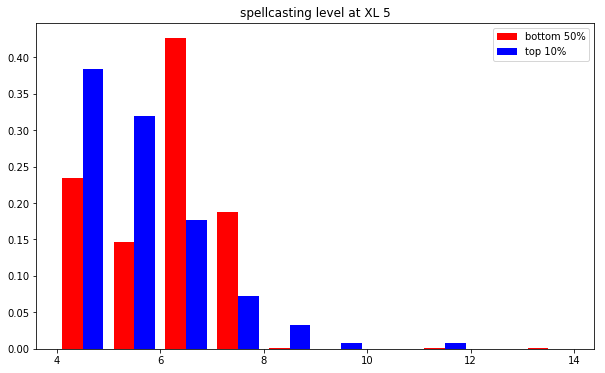

In [140]:
skill = 'spellcasting'
quant_groups = [['0-25%', '25-50%'], ['90-95%', '95-100%']]
quant_labels = ['bottom 50%', 'top 10%']
itop = g['quantile'].isin(quant_groups[1])
ibot = g['quantile'].isin(quant_groups[0])
compare_skill_allocation_at_level(skill, 5, mydf, default=4,
                                  group_indices=[ibot, itop],
                                  group_names=quant_labels,
                                 );

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:41: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


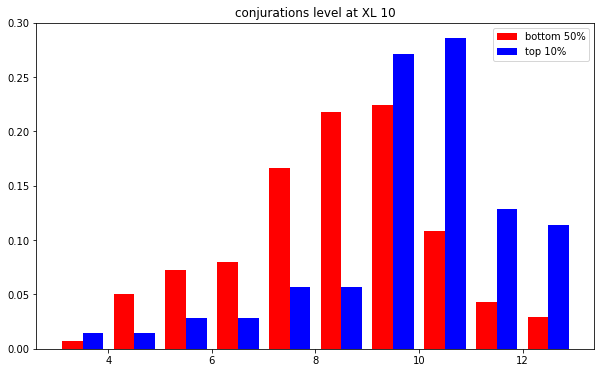

In [144]:
skill = 'conjurations'
xl = 10
compare_skill_allocation_at_level(skill, xl, mydf, default=1,
                                  group_indices=[ibot, itop],
                                  group_names=quant_labels,
                                 );

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:41: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


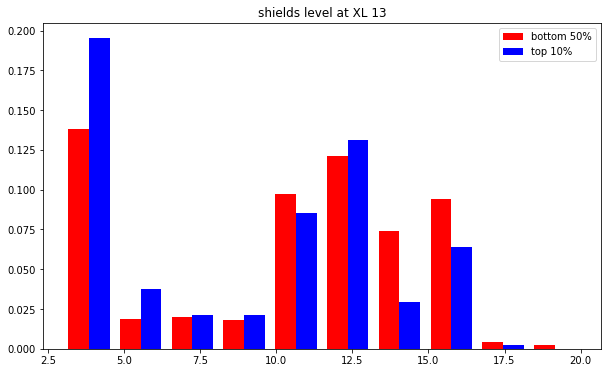

In [149]:
skill = 'shields'
sps = ['minotaur']
bgs = ['fighter']
mydf = g.loc[g['species'].isin(sps) & g['bg'].isin(bgs)]
xl = 13
compare_skill_allocation_at_level(skill, xl, mydf, default=3,
                                  group_indices=[ibot, itop],
                                  group_names=quant_labels,
                                 );

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:41: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


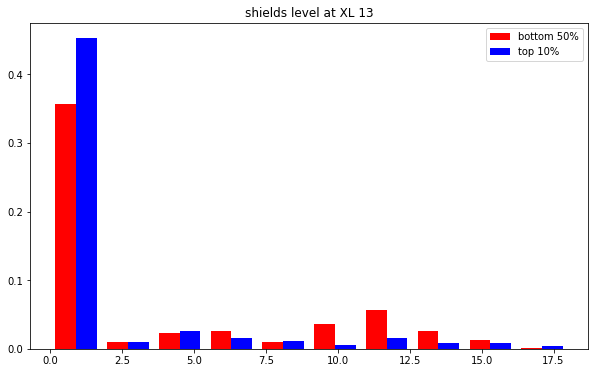

In [152]:
skill = 'shields'
sps = ['minotaur']
bgs = ['berserker']
mydf = g.loc[g['species'].isin(sps) & g['bg'].isin(bgs)]
xl = 13
compare_skill_allocation_at_level(skill, xl, mydf, default=0,
                                  group_indices=[ibot, itop],
                                  group_names=quant_labels,
                                 );

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:41: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


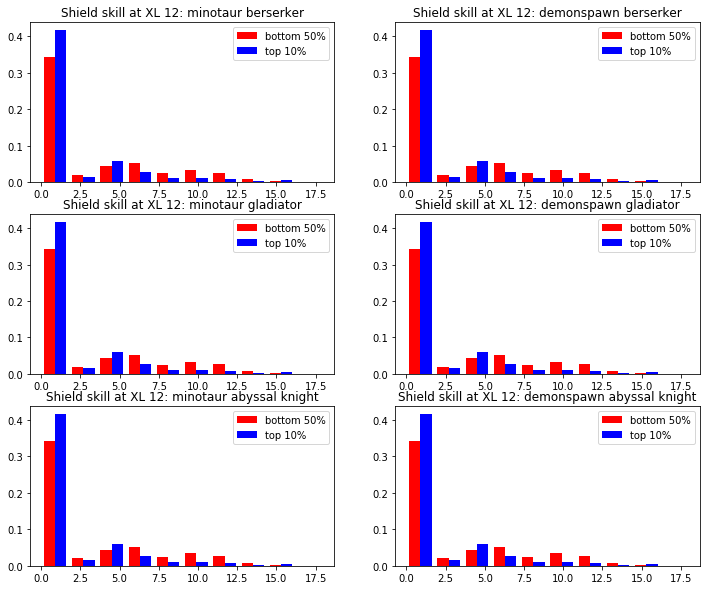

In [157]:
skill = 'shields'
sps = ['minotaur', 'demonspawn', ]
bgs = ['berserker', 'gladiator', 'abyssal knight']
mydf = g.loc[g['species'].isin(sps) & g['bg'].isin(bgs)]
xl = 12
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12,10))
for x, sp in enumerate(sps):
    for y, bg in enumerate(bgs):
        ax = axes[y][x]
        compare_skill_allocation_at_level(skill, xl, mydf, default=0,
                                  group_indices=[ibot, itop],
                                  group_names=quant_labels,
                                  ax=ax
                                 );
        ax.set_title("Shield skill at XL {}: {} {}".format(xl, sp, bg))

In [ ]:
g[( (g['quantile'].isin(['25-50%', '0-25%'])) & (g['species']=='minotaur') 
   & (g['bg']=='fighter')
 & (g['version'] > 0.17))
 ]['level'].value_counts()

In [150]:
g.groupby(['species', 'bg']).size().sort_values(ascending=0).head(20)

species     bg                
minotaur    fighter               47096
            berserker             33602
gargoyle    fighter               28863
deep elf    conjurer              26082
spriggan    enchanter             25335
demonspawn  fighter               24566
            gladiator             23945
deep elf    wizard                21697
formicid    fighter               21381
hill orc    fighter               19785
octopode    transmuter            18407
demonspawn  abyssal knight        18281
deep elf    fire elementalist     17106
demonspawn  monk                  15906
troll       monk                  14823
gargoyle    earth elementalist    14499
demonspawn  berserker             13934
draconian   transmuter            13803
vampire     enchanter             12112
high elf    skald                 11480
dtype: int64

In [52]:
sk['skill'].value_counts()

fighting          387996
dodging           294031
armour            243828
axes              197452
shields           146819
spellcasting      140519
stealth           126209
maces & flails    124020
conjurations      117418
unarmed combat     89003
long blades        87394
invocations        83733
evocations         71106
short blades       68403
polearms           59890
throwing           40790
charms             37477
hexes              30337
fire magic         28735
air magic          27080
transmutations     27016
earth magic        26459
necromancy         21572
ice magic          21147
staves             18986
bows               18690
poison magic       16427
translocations     16282
summonings         14821
crossbows          12527
slings             11915
Name: skill, dtype: int64

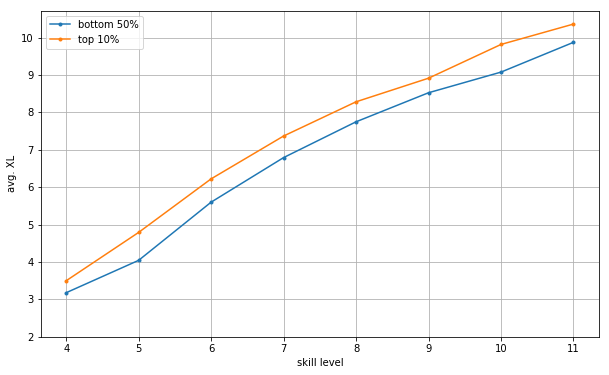

In [44]:
sps = ['deep elf']
bgs = ['wizard', 'conjurer', 'fire elementalist', 'air elementalist', 
      'earth elementalist', 'ice elementalist', 'summoner']
plot_progress(sps, bgs);

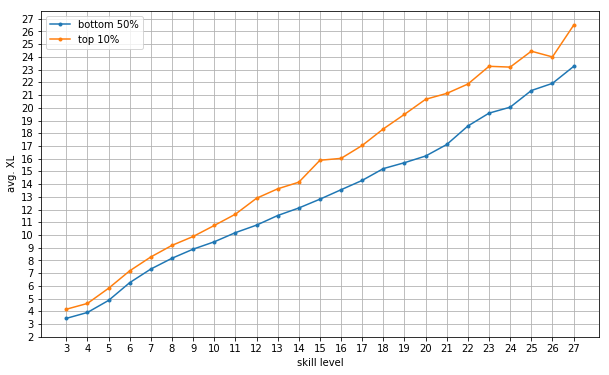

In [48]:
sps = ['deep elf', 'human', 'tengu', 'octopode', 'high elf']
bgs = ['wizard', 'conjurer', 'fire elementalist', 'air elementalist', 
      'earth elementalist', 'ice elementalist', 'summoner']
plot_progress(sps, bgs, nlvls=27);

In [30]:
((g['quantile']=='0-25%') & (g['species']=='deep elf') & (g['bg']=='wizard')
 & (g['version'] > 0.17)
 & (g['level'] > 8)
).sum()

63

In [46]:
g[( (g['quantile'].isin(['25-50%', '0-25%'])) & (g['species'].isin(sps)) 
   & (g['bg'].isin(bgs))
 & (g['version'] > 0.17))
 ]['level'].value_counts()

1     2212
3     1902
4     1835
2     1598
5     1502
6     1126
7      956
8      774
9      716
10     628
11     522
12     197
13     156
14     102
15      94
16      77
17      41
18      32
27      23
21      14
19      12
20       9
22       8
23       8
25       7
24       6
26       4
Name: level, dtype: int64

In [35]:
g[( (g['quantile'].isin(['25-50%', '0-25%'])) & (g['species']=='deep elf') 
   & (g['bg']=='wizard')
 & (g['version'] > 0.17))
 ]['level'].value_counts()

1     216
3     177
2     158
4     150
5     128
7     104
6      96
8      75
9      56
10     49
11     43
13     17
12      9
15      6
27      4
14      4
17      3
16      2
19      2
22      2
25      2
26      1
18      1
21      1
20      0
23      0
24      0
Name: level, dtype: int64